# Diffusion Model

> Neural net modules

In [1]:
#| default_exp modules

In [2]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [3]:
#| export
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision.transforms import transforms

import logging
import warnings
from omegaconf import OmegaConf
from hydra.utils import instantiate
from tqdm.notebook import tqdm

from PIL import Image
from matplotlib import pyplot as plt

from nimrod.utils import get_device, set_seed
from nimrod.image.datasets import ImageDataset

from diffusers import UNet2DModel, DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup

[10:38:02] INFO - PyTorch version 2.5.1 available.
Seed set to 42


In [4]:
#| export
set_seed(42)
logger = logging.getLogger(__name__)
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.image")

Seed set to 42


## Data

[10:38:06] INFO - Init ImageDataModule for mnist
[10:38:23] INFO - split train into train/val [0.8, 0.2]
[10:38:23] INFO - train: 48000 val: 12000, test: 10000


num_classes: 10, batch_size: 256
labels: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
X: torch.Size([1, 32, 32]), Y: 7
X: torch.Size([256, 1, 32, 32]), Y: torch.Size([256])


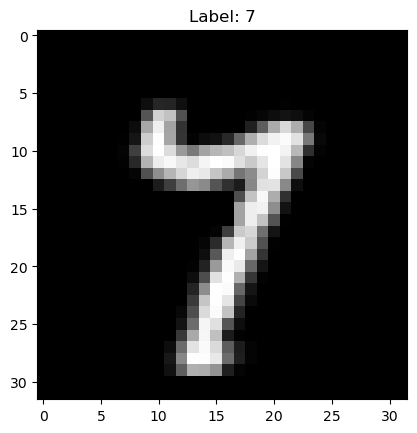

In [5]:
cfg = OmegaConf.load('../config/data/image/mnist.yaml')
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(32),
    transforms.Normalize((0.1307,), (0.3081,))
])
dm = instantiate(cfg, batch_size=64, transforms=transforms)
dm.prepare_data()
dm.setup()
print(f"num_classes: {dm.num_classes}, batch_size: {dm.batch_size}")
print(f"labels: {dm.label_names}")
x, y = dm.test_ds[0]
print(f"X: {x.shape}, Y: {y}")
x,y = next(iter(dm.train_dataloader()))
print(f"X: {x.shape}, Y: {y.shape}")
B,C,H,W = x.shape
dm.show(1)

torch.Size([1, 32, 32])


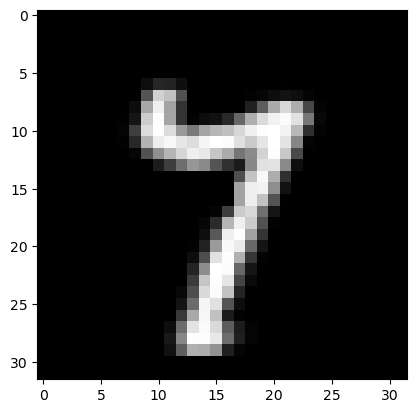

In [6]:
sample_image, _ = dm.train_ds[1]
print(sample_image.shape)
plt.imshow(sample_image.numpy().transpose(1,2,0), cmap='gray')

## DDPM Noise Scheduler: Noisify

In [7]:
NOISE_TIME_STEPS = 100
noise_scheduler = DDPMScheduler(num_train_timesteps=NOISE_TIME_STEPS)

### Usage

torch.Size([256, 1, 32, 32])


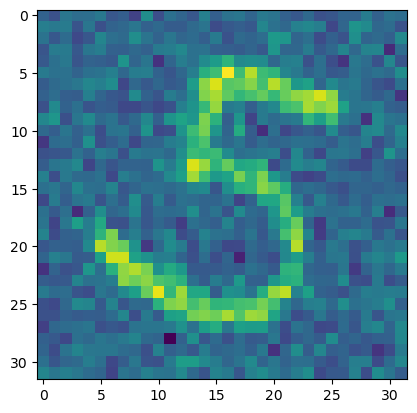

In [8]:
# generate gaussian noise images of shape (B, C, H, W)
noise = torch.randn(x.shape)
time_step = torch.LongTensor([50])

noisy_image = noise_scheduler.add_noise(x, noise, time_step)

print(noisy_image.shape)
plt.imshow(noisy_image[0].numpy().transpose(1,2,0))

## U-Net: Noise prediction

In [9]:
B,C,H,W = x.shape
model = UNet2DModel(
    in_channels=C, 
    out_channels=C, 
    block_out_channels=(32, 64, 128, 128)
    )

### Usage

torch.Size([256, 1, 32, 32])


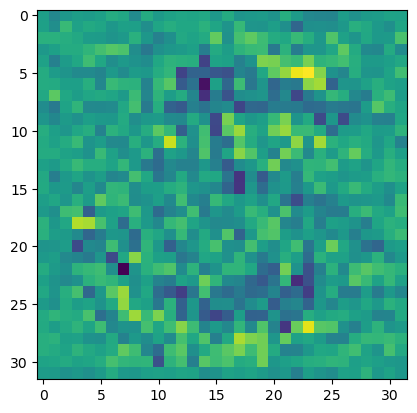

In [10]:
# predict noise from noisy image at time_step
time_step = torch.LongTensor([50])
noise_pred = model(noisy_image, time_step).sample
print(noise_pred.shape)
plt.imshow(noise_pred[0].detach().numpy().transpose(1,2,0))

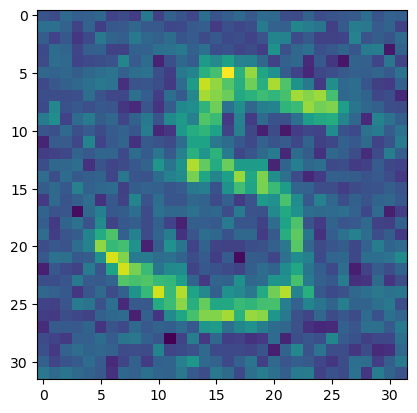

In [11]:
# substract noise from noisy image
denoised_img = noisy_image[0] - noise_pred[0]
plt.imshow(denoised_img.detach().numpy().transpose(1,2,0))

In [12]:
loss = F.mse_loss(noise_pred, noise)
print(loss)

tensor(1.1024, grad_fn=<MseLossBackward0>)


## Training

### LR scheduler & optimizer

In [13]:
device = get_device()
print(f"device: {device}")

NUM_EPOCHS = 5
lr = 1e-4
lr_warmup_steps = 5
# total steps =number of batches * num_epochs
num_training_steps = len(dm.train_dataloader()) * NUM_EPOCHS
print(f"num_training_steps: {num_training_steps}")

model = UNet2DModel(
    in_channels=C,
    out_channels=C,
    block_out_channels=(32, 64, 128, 128)
    )

model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

criterion = nn.MSELoss()

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=lr_warmup_steps,
    num_training_steps=num_training_steps
)


[10:38:25] INFO - Using device: mps


device: mps
num_training_steps: 940


### Training Loop

In [14]:
def generate_image(model, images_shape, device, noise_scheduler):
    model.eval()
    # denoisify random image
    with torch.no_grad():
        # start with noise
        noise_img = torch.randn(images_shape).to(device)
        image_gen = noise_img
        for t in noise_scheduler.timesteps:
            # predict noise 
            noisy_residual = model(image_gen, t).sample
            # compute previous image
            previous_noisy_sample = noise_scheduler.step(noisy_residual, t, image_gen).prev_sample
            image = previous_noisy_sample

        image = (image / 2 + 0.5).clamp(0, 1)
        return image

        # plt.imshow(image[0].permute(1,2,0).cpu().numpy())

In [ ]:

for epoch in range(NUM_EPOCHS):
    i = 0
    model.train()
    n_steps, loss = 0, 0
    for step, (images, labels) in tqdm(enumerate(dm.train_dataloader()), total=len(dm.train_dataloader())):
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        # sample noise
        noise = torch.randn(images.shape).to(device)
        # sample random timesteps
        timesteps = torch.randint(0, NOISE_TIME_STEPS, (images.shape[0],)).to(device)
        # create noisy image at timestep with noise scheduler
        noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
        # train model to predict noise
        outputs = model(noisy_images, timesteps, return_dict=False)[0]
        # output should be as close to input as possible
        loss = criterion(outputs, noise)
        n_steps += len(images)
        loss += (loss.item() * len(images))
        # logger.info(f"loss.item(): {loss.item()}, len(images): {len(images)}")
        # logger.info(f"Epoch: {epoch}, step: {step}, n_steps: {n_steps}, loss: {loss}")
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

    logger.info(f"Train loss: {loss / n_steps}")

    model.eval()
    total_loss, n_steps = 0, 0
    for step, (images, labels) in tqdm(enumerate(dm.val_dataloader()), total=len(dm.val_dataloader())):
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        # sample noise
        noise = torch.randn(images.shape).to(device)
        # sample random timesteps
        timesteps = torch.randint(0, NOISE_TIME_STEPS, (images.shape[0],)).to(device)
        # create noisy image at timestep with noise scheduler
        noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
        # train model to predict noise
        outputs = model(noisy_images, timesteps, return_dict=False)[0]
        # output should be as close to input as possible
        loss = criterion(outputs, noise)
        n_steps += len(images) # bs
        total_loss += loss.item() * len(images)
        logger.info(f"Epoch: {epoch}, step: {step}, n_steps: {n_steps}, loss: {loss}")
logger.info(f"Valloss: {total_loss / n_steps}") 


  0%|          | 0/188 [00:00<?, ?it/s]

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()